# Overview

In this example, we are going to conduct high-throughput virtual screening on the WDR domain of LRRK2 protein.

As an example, we only use a subset (10,000 entries) of the Mcule library. It could be any library (for examples ZINC, Enamine, etc.) as long as it contains the smiles information.


In [1]:
tankbind_src_folder_path = "../tankbind/"
import sys
sys.path.insert(0, tankbind_src_folder_path)

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
base_pre = f"./HTVS/"
# HTVS folder contains two files, 1. the Mcule library, 2. the WDR domain PDB 6dlo
d = pd.read_csv("./HTVS/Mcule_10000.csv", index_col=0)

# get protein feature

In [4]:
from feature_utils import get_protein_feature

In [5]:
from Bio.PDB import PDBParser
from feature_utils import get_clean_res_list
parser = PDBParser(QUIET=True)
protein_dict = {}
proteinName = "6dlo"
proteinFile = f"{base_pre}/{proteinName}.pdb"
s = parser.get_structure("example", proteinFile)
res_list = list(s.get_residues())
clean_res_list = get_clean_res_list(res_list, ensure_ca_exist=True)
protein_dict[proteinName] = get_protein_feature(clean_res_list)

# p2rank to segment the protein

In [6]:
ds = f"{base_pre}/protein_list.ds"
with open(ds, "w") as out:
    out.write(f"/{proteinName}.pdb\n")

In [7]:
p2rank = "bash /packages/p2rank_2.3/prank"
cmd = f"{p2rank} predict {ds} -o {base_pre}/p2rank -threads 1"
os.system(cmd)

0

In [8]:
info = []
for i, line in tqdm(d.iterrows(), total=d.shape[0]):
    smiles = line['smiles']
    compound_name = ""
    protein_name = proteinName
    # use protein center as the pocket center.
    com = ",".join([str(a.round(3)) for a in protein_dict[proteinName][0].mean(axis=0).numpy()])
    info.append([protein_name, compound_name, smiles, "protein_center", com])
    # since WDR is actually small enough, and we are interested in finding a ligand binds to the central cavity.
    # the block centered at the centroid of the protein is enough.
    # we don't need additional p2rank predicted centers.
    if False:
        p2rankFile = f"{base_pre}/p2rank/{proteinName}.pdb_predictions.csv"
        pocket = pd.read_csv(p2rankFile)
        pocket.columns = pocket.columns.str.strip()
        pocket_coms = pocket[['center_x', 'center_y', 'center_z']].values
        for ith_pocket, com in enumerate(pocket_coms):
            com = ",".join([str(a.round(3)) for a in com])
            info.append([protein_name, compound_name, smiles, f"pocket_{ith_pocket+1}", com])
info = pd.DataFrame(info, columns=['protein_name', 'compound_name', 'smiles', 'pocket_name', 'pocket_com'])
info

100%|██████████| 10000/10000 [00:00<00:00, 13328.92it/s]


,protein_name,compound_name,smiles,pocket_name,pocket_com
0,6dlo,,CC1=C(C2=CC=C(F)C=C2)N=C(NC(C2=C(C)C3=C(CCCC3=...,protein_center,"-18.041,-13.011,7.779"
1,6dlo,,CC(N(C(NC1C2OC(CC2)C1)=O)C)CS(C)(=O)=O,protein_center,"-18.041,-13.011,7.779"
2,6dlo,,S(=O)(=O)(C1C=CC2=C(C=1)N=C(N2C1CCCC1)C)N1CCC(...,protein_center,"-18.041,-13.011,7.779"
3,6dlo,,N1CCCCC1CC1=CC=NC=C1,protein_center,"-18.041,-13.011,7.779"
4,6dlo,,N1(CCC2C=CC(CNC(=O)NC3=CC=CC=C3C)=CC1=2)C(C1=C...,protein_center,"-18.041,-13.011,7.779"
...,...,...,...,...,...
9995,6dlo,,CCCN(C(OC(C)(C)C)=O)CCNC(C1=C(SC)C=CC=C1)=O,protein_center,"-18.041,-13.011,7.779"
9996,6dlo,,N[C@H](C1C=NC=CC=1Br)C(F)(F)F,protein_center,"-18.041,-13.011,7.779"
9997,6dlo,,C12N=CN(C(=O)C=1N=NN2CC1C=CC(=CC=1)F)CC(=O)NC1...,protein_center,"-18.041,-13.011,7.779"
9998,6dlo,,N1(CCC[C@H](O)[C@@H]1CC1=CC=CC=C1F)CC1C=CC=CC=...,protein_center,"-18.041,-13.011,7.779"


# construct dataset

In [9]:
import torch
torch.set_num_threads(1)

In [10]:
from torch_geometric.data import Dataset
from utils import construct_data_from_graph_gvp
import rdkit.Chem as Chem    # conda install rdkit -c rdkit if import failure.
from feature_utils import extract_torchdrug_feature_from_mol, get_canonical_smiles

In [12]:
class MyDataset_VS(Dataset):
    def __init__(self, root, data=None, protein_dict=None, proteinMode=0, compoundMode=1,
                pocket_radius=20, shake_nodes=None,
                 transform=None, pre_transform=None, pre_filter=None):
        self.data = data
        self.protein_dict = protein_dict
        super().__init__(root, transform, pre_transform, pre_filter)
        print(self.processed_paths)
        self.data = torch.load(self.processed_paths[0])
        self.protein_dict = torch.load(self.processed_paths[1])
        self.proteinMode = proteinMode
        self.pocket_radius = pocket_radius
        self.compoundMode = compoundMode
        self.shake_nodes = shake_nodes
    @property
    def processed_file_names(self):
        return ['data.pt', 'protein.pt']

    def process(self):
        torch.save(self.data, self.processed_paths[0])
        torch.save(self.protein_dict, self.processed_paths[1])

    def len(self):
        return len(self.data)

    def get(self, idx):
        line = self.data.iloc[idx]
        smiles = line['smiles']
        pocket_com = line['pocket_com']
        pocket_com = np.array(pocket_com.split(",")).astype(float) if type(pocket_com) == str else pocket_com
        pocket_com = pocket_com.reshape((1, 3))
        use_whole_protein = line['use_whole_protein'] if "use_whole_protein" in line.index else False

        protein_name = line['protein_name']
        protein_node_xyz, protein_seq, protein_node_s, protein_node_v, protein_edge_index, protein_edge_s, protein_edge_v = self.protein_dict[protein_name]

        try:
            smiles = get_canonical_smiles(smiles)
            mol = Chem.MolFromSmiles(smiles)
            mol.Compute2DCoords()
            coords, compound_node_features, input_atom_edge_list, input_atom_edge_attr_list, pair_dis_distribution = extract_torchdrug_feature_from_mol(mol, has_LAS_mask=True)
        except:
            print("something wrong with ", smiles, "to prevent this stops our screening, we repalce it with a placeholder smiles 'CCC'")
            smiles = 'CCC'
            mol = Chem.MolFromSmiles(smiles)
            mol.Compute2DCoords()
            coords, compound_node_features, input_atom_edge_list, input_atom_edge_attr_list, pair_dis_distribution = extract_torchdrug_feature_from_mol(mol, has_LAS_mask=True)
        # y is distance map, instead of contact map.
        data, input_node_list, keepNode = construct_data_from_graph_gvp(protein_node_xyz, protein_seq, protein_node_s, 
                              protein_node_v, protein_edge_index, protein_edge_s, protein_edge_v,
                              coords, compound_node_features, input_atom_edge_list, input_atom_edge_attr_list,
                              pocket_radius=self.pocket_radius, use_whole_protein=use_whole_protein, includeDisMap=True,
                              use_compound_com_as_pocket=False, chosen_pocket_com=pocket_com, compoundMode=self.compoundMode)
        data.compound_pair = pair_dis_distribution.reshape(-1, 16)

        return data


In [13]:
dataset_path = f"{base_pre}/dataset/"
os.system(f"rm -r {dataset_path}")
os.system(f"mkdir -p {dataset_path}")
dataset = MyDataset_VS(dataset_path, data=info, protein_dict=protein_dict)

['HTVS/dataset/processed/data.pt', 'HTVS/dataset/processed/protein.pt']


Processing...
Done!


In [14]:
dataset = MyDataset_VS(dataset_path)

['HTVS/dataset/processed/data.pt', 'HTVS/dataset/processed/protein.pt']


In [15]:
import logging
from torch_geometric.loader import DataLoader
from tqdm import tqdm    # pip install tqdm if fails.
from model import get_model

# take about 2 minutes to screen 10,000 drug candidates.

In [ ]:
batch_size = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device= 'cpu'
logging.basicConfig(level=logging.INFO)
model = get_model(0, logging, device)
# modelFile = "../saved_models/re_dock.pt"
# self-dock model
modelFile = "../saved_models/self_dock.pt"

model.load_state_dict(torch.load(modelFile, map_location=device))
_ = model.eval()

data_loader = DataLoader(dataset, batch_size=batch_size, follow_batch=['x', 'y', 'compound_pair'], shuffle=False, num_workers=8)
affinity_pred_list = []
y_pred_list = []
for data in tqdm(data_loader):
    data = data.to(device)
    y_pred, affinity_pred = model(data)
    affinity_pred_list.append(affinity_pred.detach().cpu())
    if False:
        # we don't need to save the predicted distance map in HTVS setting.
        for i in range(data.y_batch.max() + 1):
            y_pred_list.append((y_pred[data['y_batch'] == i]).detach().cpu())

affinity_pred_list = torch.cat(affinity_pred_list)

In [17]:
info = dataset.data
info['affinity'] = affinity_pred_list

In [18]:
info.to_csv(f"{base_pre}/result_info.csv")

In [19]:
import matplotlib.pylab as plt
%matplotlib inline

In [21]:
chosen = info.loc[info.groupby(['protein_name', 'smiles'],sort=False)['affinity'].agg('idxmax')].reset_index()
chosen

,index,protein_name,compound_name,smiles,pocket_name,pocket_com,affinity
0,0,6dlo,,CC1=C(C2=CC=C(F)C=C2)N=C(NC(C2=C(C)C3=C(CCCC3=...,protein_center,"-18.041,-13.011,7.779",4.058674
1,1,6dlo,,CC(N(C(NC1C2OC(CC2)C1)=O)C)CS(C)(=O)=O,protein_center,"-18.041,-13.011,7.779",2.428341
2,2,6dlo,,S(=O)(=O)(C1C=CC2=C(C=1)N=C(N2C1CCCC1)C)N1CCC(...,protein_center,"-18.041,-13.011,7.779",4.348085
3,3,6dlo,,N1CCCCC1CC1=CC=NC=C1,protein_center,"-18.041,-13.011,7.779",1.786636
4,4,6dlo,,N1(CCC2C=CC(CNC(=O)NC3=CC=CC=C3C)=CC1=2)C(C1=C...,protein_center,"-18.041,-13.011,7.779",4.266350
...,...,...,...,...,...,...,...
9995,9995,6dlo,,CCCN(C(OC(C)(C)C)=O)CCNC(C1=C(SC)C=CC=C1)=O,protein_center,"-18.041,-13.011,7.779",4.467056
9996,9996,6dlo,,N[C@H](C1C=NC=CC=1Br)C(F)(F)F,protein_center,"-18.041,-13.011,7.779",3.371897
9997,9997,6dlo,,C12N=CN(C(=O)C=1N=NN2CC1C=CC(=CC=1)F)CC(=O)NC1...,protein_center,"-18.041,-13.011,7.779",3.700587
9998,9998,6dlo,,N1(CCC[C@H](O)[C@@H]1CC1=CC=CC=C1F)CC1C=CC=CC=...,protein_center,"-18.041,-13.011,7.779",2.832194


<AxesSubplot:>

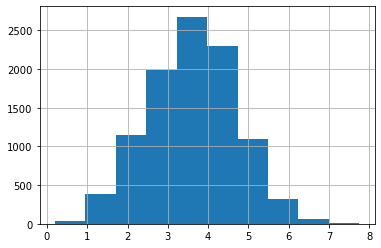

In [22]:
chosen.affinity.hist()

In [ ]:
from generation_utils import get_LAS_distance_constraint_mask, get_info_pred_distance, write_with_new_coords
# pick one with affinity greater than 7.
chosen = info.loc[info.groupby(['protein_name', 'smiles'],sort=False)['affinity'].agg('idxmax')].reset_index()
chosen = chosen.query("affinity > 7").reset_index(drop=True)
line = chosen.iloc[0]
idx = line['index']
one_data = dataset[idx]
data_with_batch_info = next(iter(DataLoader(dataset[idx:idx+1], batch_size=1, 
                         follow_batch=['x', 'y', 'compound_pair'], shuffle=False, num_workers=1)))
y_pred, affinity_pred = model(data_with_batch_info)

coords = one_data.coords.to(device)
protein_nodes_xyz = one_data.node_xyz.to(device)
n_compound = coords.shape[0]
n_protein = protein_nodes_xyz.shape[0]
y_pred = y_pred.reshape(n_protein, n_compound).to(device).detach()
y = one_data.dis_map.reshape(n_protein, n_compound).to(device)
compound_pair_dis_constraint = torch.cdist(coords, coords)

In [26]:
smiles = line['smiles']
print(smiles)
mol = Chem.MolFromSmiles(smiles)
mol.Compute2DCoords()
LAS_distance_constraint_mask = get_LAS_distance_constraint_mask(mol).bool()
info = get_info_pred_distance(coords, y_pred, protein_nodes_xyz, compound_pair_dis_constraint, 
                              LAS_distance_constraint_mask=LAS_distance_constraint_mask,
                              n_repeat=1, show_progress=False)
toFile = f'{base_pre}/one_tankbind.sdf'
new_coords = info.sort_values("loss")['coords'].iloc[0].astype(np.double)
write_with_new_coords(mol, new_coords, toFile)

C12C(C3C=CC=C(Cl)C=3)=NC(=CC=1C1C(=CC=CC=1)N2)C(=O)NCC1C=CC(=CC=1)C


In [ ]:
import nglview   # conda install nglview -c conda-forge if import failure

proteinName = "6dlo"
proteinFile = f"{base_pre}/{proteinName}.pdb"
view = nglview.show_file(nglview.FileStructure(proteinFile), default=False)
view.add_representation('cartoon', selection='protein', color='white')

predictedFile = f'{base_pre}/one_tankbind.sdf'
rdkit = view.add_component(nglview.FileStructure(predictedFile), default=False)
rdkit.add_ball_and_stick(color='red')
view

In [ ]:
view.render_image()

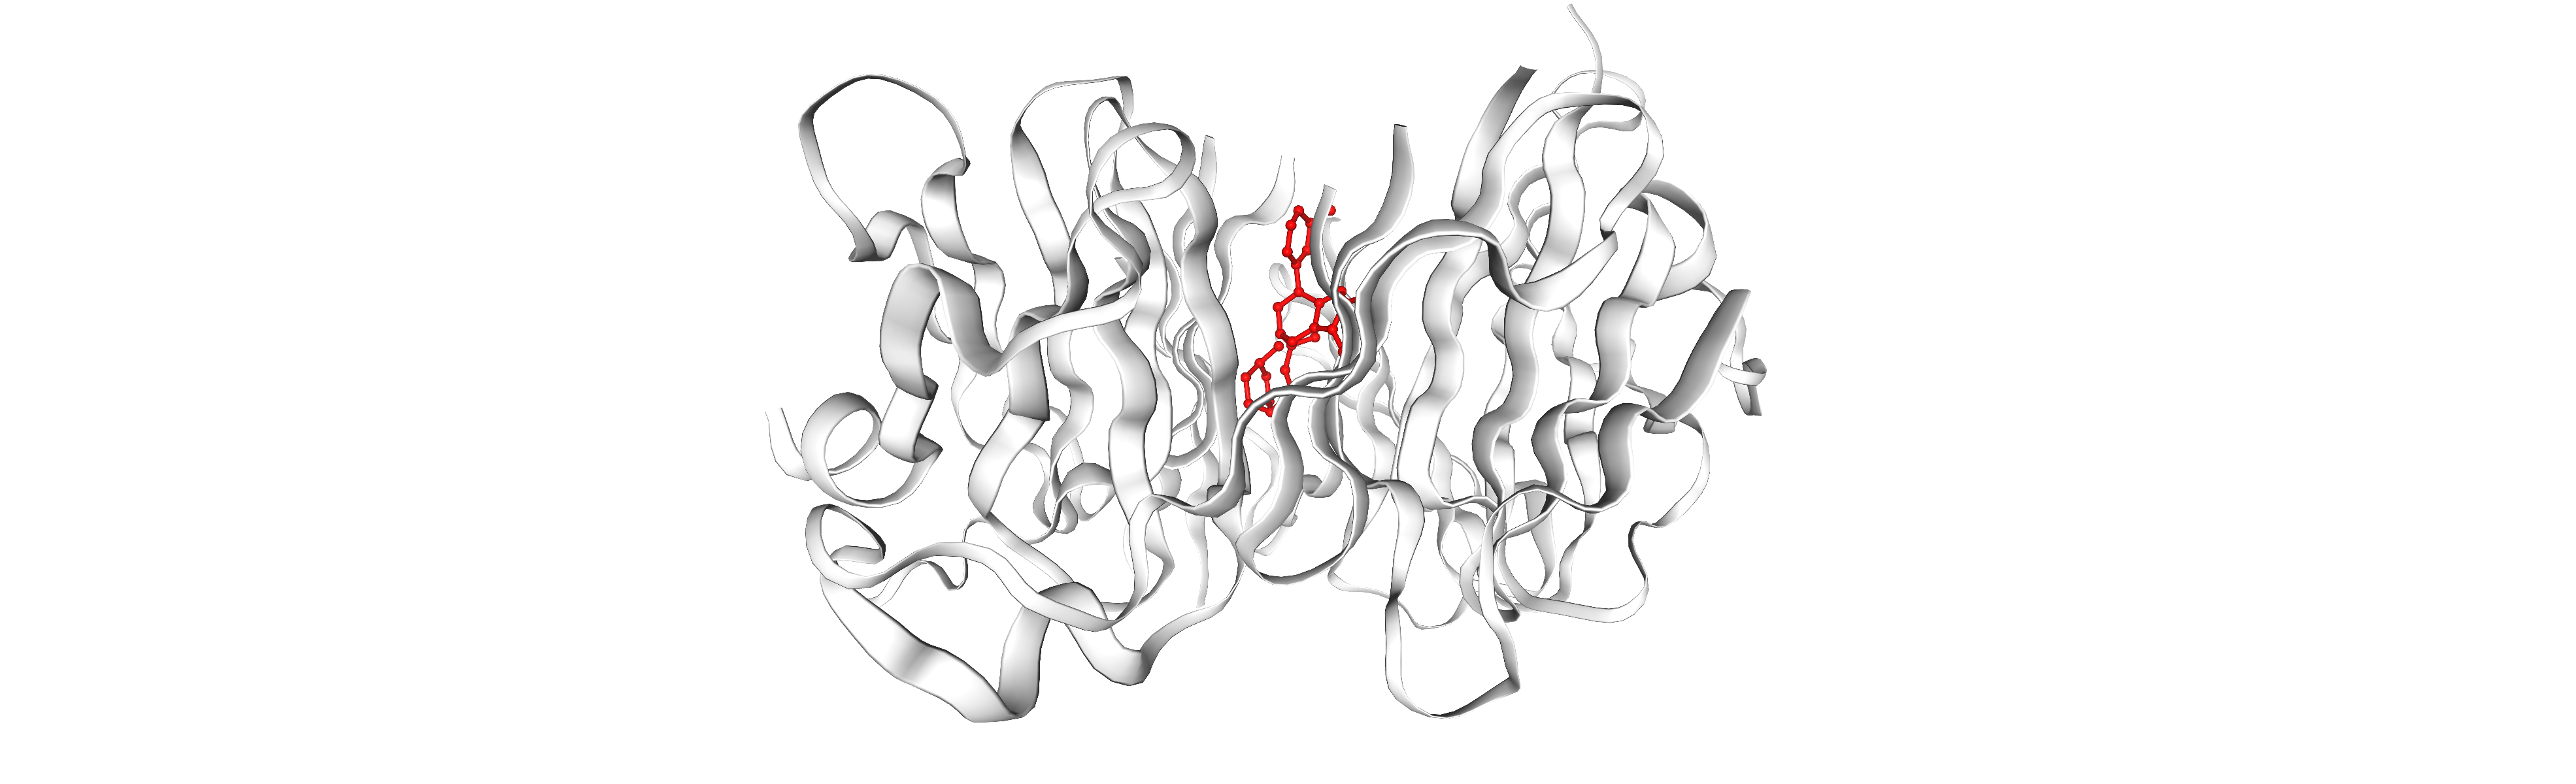

In [29]:
view._display_image()